## POC

In [1]:
import torch
from torch import nn

In [2]:
class SmolNet(nn.Module):
    def __init__(self) -> None:
        super(SmolNet, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 30)
        self.fc3 = nn.Linear(30, 5)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [3]:
smol = SmolNet()
smol

SmolNet(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=5, bias=True)
)

In [4]:
def hook(self, input, output):
    print(output.data)

In [5]:
smol.fc3.register_forward_hook(hook)

In [6]:
smol(torch.rand(10))

tensor([-0.2242,  0.1860, -0.0146, -0.1434,  0.1195])


tensor([-0.2242,  0.1860, -0.0146, -0.1434,  0.1195], grad_fn=<AddBackward0>)

## ResNet

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tempo.data.datasets import finetune_dataset
from tempo.models import NewTempoLinear

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}.')

Using device: cuda.


In [3]:
train_loader_ft = finetune_dataset(name='ASL-big', train=True, batch_size=10)
test_loader_ft = finetune_dataset(train=False, batch_size=10)

In [4]:
weights = torch.load("./model_zoo/baseline.pth")
model = NewTempoLinear(out_features=24, weights=None, freeze_backbone=True)
model.load_state_dict(weights)
_ = model.to(device)

In [5]:
from linear_eval import linear_eval_new

In [6]:
losses, errors, iters = linear_eval_new(3_000, model, train_loader_ft, test_loader_ft, device)

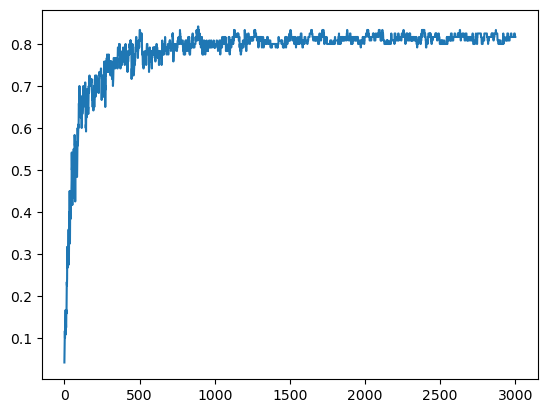

In [7]:
plt.plot(iters, errors)

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tempo.data.datasets import finetune_dataset
from tempo.models import NewTempoLinear

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}.')

Using device: cuda.


In [3]:
train_loader_ft = finetune_dataset(name='ASL-big', train=True, batch_size=1)
test_loader_ft = finetune_dataset(train=False, batch_size=1)

In [4]:
weights = torch.load("./model_zoo/baseline.pth")
model = NewTempoLinear(out_features=24, weights=None, freeze_backbone=True)
model.load_state_dict(weights)
model.to(device)

NewTempoLinear(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [5]:
def get_features(reps, layer):
    def hook(model, input, output):
        reps[layer].append(output.data)
    return hook

In [6]:
reps = {
    'l1': [],
    'l2': [],
    'l3': [],
    'l4': [],
    'labels': []
}

test_reps = {
    'l1': [],
    'l2': [],
    'l3': [],
    'l4': [],
    'labels': []
}

In [7]:
h1 = model.backbone[4].register_forward_hook(get_features(reps, 'l1'))
h2 = model.backbone[5].register_forward_hook(get_features(reps, 'l2'))
h3 = model.backbone[6].register_forward_hook(get_features(reps, 'l3'))
h4 = model.backbone.register_forward_hook(get_features(reps, 'l4'))

In [8]:
# Compute train representations

with torch.no_grad():
    for input, label in train_loader_ft:

        _ = model.backbone(input.to(device)).detach()
        reps['labels'].append(label)

In [9]:
reps['l1'] = torch.cat(reps['l1'], dim=0)
reps['l2'] = torch.cat(reps['l2'], dim=0)
reps['l3'] = torch.cat(reps['l3'], dim=0)
reps['l4'] = torch.cat(reps['l4'], dim=0)

In [10]:
reps['l1'].shape

torch.Size([3754, 64, 32, 32])

In [11]:
reps['labels'].__len__()

3754

In [12]:
train_reps = zip(reps['l3'], reps['labels'])
r, l = next(iter(train_reps))
r.shape, l

(torch.Size([256, 8, 8]), tensor([7]))

In [13]:
h1.remove()
h2.remove()
h3.remove()
h4.remove()

In [14]:
model.backbone[4]._forward_hooks, model.backbone[5]._forward_hooks, model.backbone[6]._forward_hooks, model.backbone._forward_hooks 

(OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict())

In [15]:
h1 = model.backbone[4].register_forward_hook(get_features(test_reps, 'l1'))
h2 = model.backbone[5].register_forward_hook(get_features(test_reps, 'l2'))
h3 = model.backbone[6].register_forward_hook(get_features(test_reps, 'l3'))
h4 = model.backbone.register_forward_hook(get_features(test_reps, 'l4'))

In [16]:
# Compute test representations

with torch.no_grad():
    for input, label in test_loader_ft:

        _ = model.backbone(input.to(device)).detach()
        test_reps['labels'].append(label)

In [17]:
test_reps['l1'] = torch.cat(test_reps['l1'], dim=0)
test_reps['l2'] = torch.cat(test_reps['l2'], dim=0)
test_reps['l3'] = torch.cat(test_reps['l3'], dim=0)
test_reps['l4'] = torch.cat(test_reps['l4'], dim=0)

In [18]:
test_reps['l1'].shape, test_reps['l2'].shape, test_reps['l3'].shape, test_reps['l4'].shape,

(torch.Size([120, 64, 32, 32]),
 torch.Size([120, 128, 16, 16]),
 torch.Size([120, 256, 8, 8]),
 torch.Size([120, 512, 1, 1]))

In [19]:
test_reps = zip(test_reps['l3'], test_reps['labels'])
r, l = next(iter(test_reps))
r.shape, l

(torch.Size([256, 8, 8]), tensor([4]))

## Test on layer 3 reps 

In [24]:
r, l = next(test_reps)
r.shape, l

StopIteration: 

In [21]:
def test_model(model, test_reps, device):

    model.eval()

    wrongly_classified = 0
    for repr, label in test_reps:
        total = repr.shape[0]

        inputs, labels = repr.flatten(start_dim=0).to(device), label.to(device)

        with torch.no_grad():
            preds = model(inputs).argmax(dim=0)

        wrong = (total - (preds == labels).sum()).item()
        wrongly_classified += wrong

    model.train()

    return 1.0 - (wrongly_classified / len(list(test_reps)))

In [22]:
def linear_eval(iterations, train_reps, test_reps, device):

    model = nn.Linear(
            in_features = 256*8*8, 
            out_features = 24, 
            bias=True
        ).to(device)

    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001)

    losses, errors, iters_ = [], [], []
    i = 0
    every = 1
    running_loss = 0.0
    b1 = False
    while True:
        for repr, label in train_reps:
            if i % every == 0:
                test_error = test_model(model, test_reps, device)
                losses.append(running_loss)
                errors.append(test_error)
                iters_.append(i)
                running_loss = 0

                if i == iterations:
                    b1=True
                    break

            labels = nn.functional.one_hot(label, num_classes=24).float()
            inputs, labels = repr.flatten(start_dim=0).to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            i += 1

        if i == iterations and b1:
            break
    losses, errors, iters_ = np.array(losses), np.array(errors), np.array(iters_)

    return (losses, errors, iters_)

In [23]:
linear_eval(3_000, train_reps, test_reps, device)

ZeroDivisionError: division by zero